# Training Models

* Closed form or Gradient Descent (Stochastic, Batch, Mini-Batch)

## Linear Regression
### Representation 
$\hat{y} = \theta^{T}\cdot x$
* Represent one instance of a prediction (an $x_i$)
* $x$ is feature vector - $x_0$ always is (1) - for constants
* $\hat{y}$ is prediction (1 value)
* $\theta^{T}$ is parameter vector. Transposed to dot because ML usually represents as column vector

### Error
$\text{MSE}(\theta) = 1/m\sum_{i=1}^{m}(\theta^Tx^i - y^i)^2$
* Diff predicted value to real value for all points (squared for non-negs)

### Closed Form Equation
Find the parameter vector that minimize MSE --- $\hat{\theta}$

$\hat{\theta} = (X^TX)^\text{-1}X^Ty$

* $X$ is matrix with row = data point, col = features
* $y$ is vector of $y_1$ to $y_m$ (1D array with m values)

### Trying it out
* Using GDP vs Hapiness data downloaded and processed in (datasets/gdp-happiness)


In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Using Closed Form

In [9]:
gdp_happiness = pd.read_csv("datasets/gdp-happiness/gdp-vs-happiness-2017.csv")
gdp_happiness.columns

Index(['Country', 'GDP Per Capita', 'Life Satisfaction'], dtype='object')

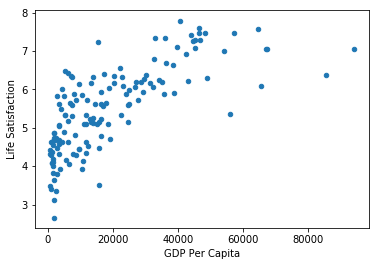

In [12]:
gdp_happiness.plot.scatter(x="GDP Per Capita", y="Life Satisfaction")

In [21]:
# Implements the closed form
def theta_best(X,y): 
    X_t = X.T
    return np.linalg.inv(X_t.dot(X)).dot(X_t).dot(y)

In [83]:
# .values to get numpy array out of pandas series
# np.c_ ~= zip

# Note: needs to add 1 to a feature for constant to show up in theta

X_gdp = np.c_[
    np.ones(gdp_happiness["GDP Per Capita"].values.size),
    gdp_happiness["GDP Per Capita"].values
]

theta_gdp_happiness = theta_best(X_gdp, gdp_happiness["Life Satisfaction"].values)

In [84]:
theta_gdp_happiness

array([4.66027944e+00, 4.31820655e-05])

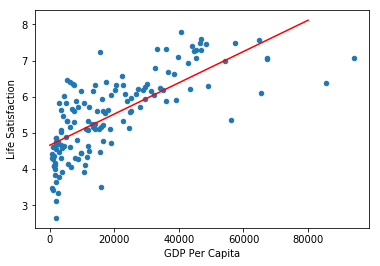

In [102]:
gdp_happiness.plot.scatter(x="GDP Per Capita", y="Life Satisfaction")
x_lin = np.linspace(0, 80000, 1000)
y_lin = theta_gdp_happiness[0] + theta_gdp_happiness[1]*x_lin
plt.plot(x_lin, y_lin, "-r")

### Using Scikit-Learn

In [91]:
# .reshape(-1,1) to make an array 2D -- even when we only have 1 feature

from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(gdp_happiness["GDP Per Capita"].values.reshape(-1,1), gdp_happiness["Life Satisfaction"].values)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [92]:
lin_reg.intercept_, lin_reg.coef_

(4.660279441576911, array([4.31820655e-05]))